In [2]:
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K

import random
import glob
!pip install wandb
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 180 kB 28.5 MB/s 
     |████████████████████████████████| 139 kB 67.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=52c0cc1906f87e3ba36987450b04773f66dcacd1bb25812b4e8d26f4dee6fa3f
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=902ae69583fac5849b1e30db2ac9a428c9ccb288a5957edef92bf5f6f129c9ab
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [3]:
hyperparams = {"num_epochs": 10, 
          "batch_size": 32,
          "height": 96,
          "width": 96}

wandb.init(config=hyperparams)
config = wandb.config

val_dir = 'catz/test'
train_dir = 'catz/train'

# automatically get the data if it doesn't exist
if not os.path.exists("catz"):
    print("Downloading catz dataset...")
    subprocess.check_output(
        "curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz", shell=True)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.width, config.height, 3 * 5))
        output_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

In [5]:
class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(15, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)

In [6]:
# Test the generator
gen = my_generator(2, train_dir)
videos, next_frame = next(gen)
videos[0].shape
next_frame[0].shape

(96, 96, 3)

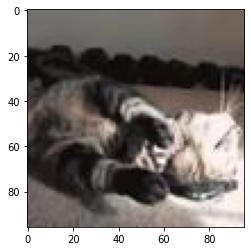

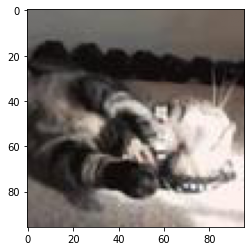

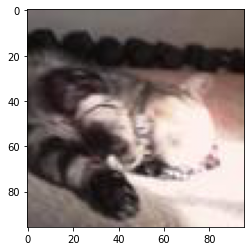

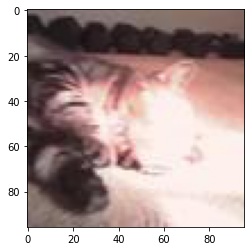

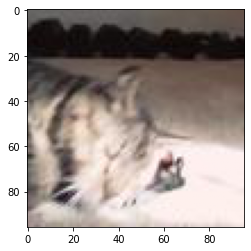

In [7]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,9:12])

figure()
imshow(next_frame[0][:,:,0:3])

In [8]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

In [9]:
wandb.init(config=hyperparams)
config = wandb.config

model = Sequential()
model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(config.height, config.width, 5 * 3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
52/52 [==============================] - 20s 379ms/step - loss: 0.0869 - perceptual_distance: 168.4505 - val_loss: 0.0329 - val_perceptual_distance: 101.5619
Epoch 2/10
52/52 [==============================] - 20s 383ms/step - loss: 0.0292 - perceptual_distance: 92.0839 - val_loss: 0.0233 - val_perceptual_distance: 79.8200
Epoch 3/10
52/52 [==============================] - 20s 371ms/step - loss: 0.0191 - perceptual_distance: 70.9513 - val_loss: 0.0170 - val_perceptual_distance: 66.1664
Epoch 4/10
52/52 [==============================] - 20s 372ms/step - loss: 0.0166 - perceptual_distance: 62.8258 - val_loss: 0.0142 - val_perceptual_distance: 58.6170
Epoch 5/10
52/52 [==============================] - 20s 373ms/step - loss: 0.0141 - perceptual_distance: 56.5854 - val_loss: 0.0127 - val_perceptual_distance: 52.5398
Epoch 6/10
52/52 [==============================] - 19s 365ms/step - loss: 0.0118 - perceptual_distance: 51.1731 - val_loss: 0.0113 - val_perceptual_distance: 49.1

In [10]:
# Baseline model - just return the last layer

from keras.layers import Lambda, Reshape, Permute

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

model=Sequential()
model.add(Reshape((96,96,5,3), input_shape=(config.height, config.width, 5 * 3)))
model.add(Permute((1,2,4,3)))
model.add(Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
perceptual_distance,█▄▃▂▂▂▁▁▁▁
val_loss,█▅▃▃▂▂▂▁▁▁
val_perceptual_distance,█▆▄▃▂▂▂▁▁▁
best_epoch,9
best_val_loss,0.00816
epoch,9
loss,0.0087
perceptual_distance,41.38088
val_loss,0.00816


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
52/52 [==============================] - 9s 175ms/step - loss: 0.0056 - perceptual_distance: 20.6798 - val_loss: 0.0058 - val_perceptual_distance: 20.8509
Epoch 2/10
52/52 [==============================] - 10s 185ms/step - loss: 0.0053 - perceptual_distance: 20.0195 - val_loss: 0.0074 - val_perceptual_distance: 22.7503
Epoch 3/10
52/52 [==============================] - 9s 181ms/step - loss: 0.0052 - perceptual_distance: 20.2596 - val_loss: 0.0054 - val_perceptual_distance: 20.0023
Epoch 4/10
52/52 [==============================] - 9s 182ms/step - loss: 0.0054 - perceptual_distance: 20.4489 - val_loss: 0.0050 - val_perceptual_distance: 18.9065
Epoch 5/10
52/52 [==============================] - 9s 183ms/step - loss: 0.0051 - perceptual_distance: 20.6391 - val_loss: 0.0046 - val_perceptual_distance: 18.6668
Epoch 6/10
52/52 [==============================] - 9s 183ms/step - loss: 0.0062 - perceptual_distance: 21.2272 - val_loss: 0.0051 - val_perceptual_distance: 19.1570
Epo

In [11]:
# Just return the last layer, functional style

from keras.layers import Lambda, Reshape, Permute, Input
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
model=Model(inputs=[inp], outputs=[last_layer])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,▄▃▂▃▂▇▁▂█▄
perceptual_distance,▅▃▄▄▄▆▃▁█▇
val_loss,▅█▄▃▂▃▄▄▄▁
val_perceptual_distance,▅█▄▃▂▃▃▅▅▁
best_epoch,9
best_val_loss,0.00403
epoch,9
loss,0.00568
perceptual_distance,21.55475
val_loss,0.00403


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
52/52 [==============================] - 9s 177ms/step - loss: 0.0048 - perceptual_distance: 19.6552 - val_loss: 0.0047 - val_perceptual_distance: 18.8599
Epoch 2/10
52/52 [==============================] - 10s 190ms/step - loss: 0.0057 - perceptual_distance: 20.9440 - val_loss: 0.0053 - val_perceptual_distance: 19.3905
Epoch 3/10
52/52 [==============================] - 9s 181ms/step - loss: 0.0056 - perceptual_distance: 21.0531 - val_loss: 0.0045 - val_perceptual_distance: 18.9834
Epoch 4/10
52/52 [==============================] - 10s 185ms/step - loss: 0.0060 - perceptual_distance: 21.2292 - val_loss: 0.0059 - val_perceptual_distance: 21.4208
Epoch 5/10
52/52 [==============================] - 9s 183ms/step - loss: 0.0058 - perceptual_distance: 20.9491 - val_loss: 0.0073 - val_perceptual_distance: 23.2826
Epoch 6/10
52/52 [==============================] - 9s 184ms/step - loss: 0.0055 - perceptual_distance: 20.1812 - val_loss: 0.0052 - val_perceptual_distance: 20.0484
Ep

In [12]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

hyperparams["num_epochs"] = 100
wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
conv_output = Conv3D(1, (3,3,3), padding="same")(permuted)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▄▄▅▄▃█▃▃▄
perceptual_distance,▁▄▄▅▄▂█▂▁▄
val_loss,▂▄▂▅█▃▅█▁▃
val_perceptual_distance,▃▃▃▆█▄▆▇▁▄
best_epoch,8
best_val_loss,0.00408
epoch,9
loss,0.00569
perceptual_distance,20.91853
val_loss,0.00486


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
52/52 [==============================] - 62s 1s/step - loss: 0.0332 - perceptual_distance: 101.3063 - val_loss: 0.0134 - val_perceptual_distance: 56.7169


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
52/52 [==============================] - 62s 1s/step - loss: 0.0128 - perceptual_distance: 52.4811 - val_loss: 0.0116 - val_perceptual_distance: 47.5743
Epoch 3/100
52/52 [==============================] - 62s 1s/step - loss: 0.0111 - perceptual_distance: 46.8619 - val_loss: 0.0124 - val_perceptual_distance: 46.8501
Epoch 4/100
52/52 [==============================] - 62s 1s/step - loss: 0.0102 - perceptual_distance: 42.9322 - val_loss: 0.0084 - val_perceptual_distance: 40.0438
Epoch 5/100
52/52 [==============================] - 62s 1s/step - loss: 0.0089 - perceptual_distance: 40.7301 - val_loss: 0.0079 - val_perceptual_distance: 39.0883
Epoch 6/100
52/52 [==============================] - 62s 1s/step - loss: 0.0093 - perceptual_distance: 40.1148 - val_loss: 0.0071 - val_perceptual_distance: 36.4183
Epoch 7/100
52/52 [==============================] - 62s 1s/step - loss: 0.0086 - perceptual_distance: 39.7684 - val_loss: 0.0070 - val_perceptual_distance: 35.8137
Epoch 8/10

In [ ]:
# Conv3D with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init()

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
conv_output = Conv3D(1, (3,3,3), padding="same")(noise)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
perceptual_distance,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▄▂▄▄▃▂▃▂▂▂▄▂▂▃▂▂▂▃▂▂▂▃▂▃▂▃▂▂▂▁▁▁▂▂▄▂▂
val_perceptual_distance,█▆▄▄▃▄▃▃▂▃▂▂▂▃▂▂▂▂▂▃▂▁▁▂▂▂▂▃▃▂▂▁▁▁▁▁▃▂▁▁
best_epoch,85
best_val_loss,0.0034
epoch,99
loss,0.0048
perceptual_distance,25.49242
val_loss,0.00538


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
52/52 [==============================] - 68s 1s/step - loss: 0.0625 - perceptual_distance: 161.3903 - val_loss: 0.0237 - val_perceptual_distance: 76.2208


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
52/52 [==============================] - 67s 1s/step - loss: 0.0401 - perceptual_distance: 130.5305 - val_loss: 0.0150 - val_perceptual_distance: 56.4315
Epoch 3/100
52/52 [==============================] - 66s 1s/step - loss: 0.0316 - perceptual_distance: 117.6796 - val_loss: 0.0103 - val_perceptual_distance: 45.4462
Epoch 4/100
52/52 [==============================] - 66s 1s/step - loss: 0.0274 - perceptual_distance: 110.1658 - val_loss: 0.0093 - val_perceptual_distance: 41.4388
Epoch 5/100
45/52 [========================>.....] - ETA: 7s - loss: 0.0246 - perceptual_distance: 104.9010

In [ ]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(6, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(3, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

In [ ]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))